## Setting things up

In [1]:
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from sklearn.isotonic import IsotonicRegression
from utils_binary_responses import *
#from utils_binary_responses import wage_f as custom_wage
from utils import *
from scipy.stats import beta as sp_beta

from scipy.interpolate import interp1d
from scipy.integrate import quad
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
from tqdm import tqdm
import time
from scipy.integrate import simps

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}  \usepackage{amssymb}  \usepackage{mathrsfs}'

In [2]:
#pip install tqdm

## Generating data: $\{(I_{(t)},\widehat{\pi}_{(t)})\}_t$

Now for every time $t \in [T]$  we generate a sequence $\theta_1,\dots, \theta_T$, let's say uniform in $\text{supp}\{f_X\}$. For every $t$ we do:

1. evaluate $I(\theta_t)$.
2. sample $n_t$ points (where $n_t$ is randomly selected between $30$ and $50$) from $X \sim \pi f_q(x)+(1-\pi)f_u(x)$ (using rejection method: histogram can be used to see how it is good, just make plot_hist=True) and estimate $\pi$ using MLE (for numerical efficiency we transform the parameter $p$ to the entire real line using the logistic function, we perform unconstrained optimization to find the MLE of the transformed parameter and then we then transform the estimated parameter back to the $p$).

In [5]:
T = 100 # T = number of deployed models
n = np.random.randint(30, 50, size=T) # n = list of number of workers for every t in [T]

wage = main_parameters()[4]
design = lambda x: indicator(x,0,wage)/wage
theta, I_val = get_theta(T,design) # theta = list of selected thresholds in supp{f_X}, I_t = sequence of I evaluated at each theta_1,...,theta_T

ordered_I_val = sorted(I_val) # Sort I_val in increasing order

F_C_name = 'Beta(3,8)' #Change to Beta(3,3) to get the other plot
F_C = get_cdf(F_C_name)
evaluations = 10

## Plot Isotonic regression and Monotone Quadratic Spline

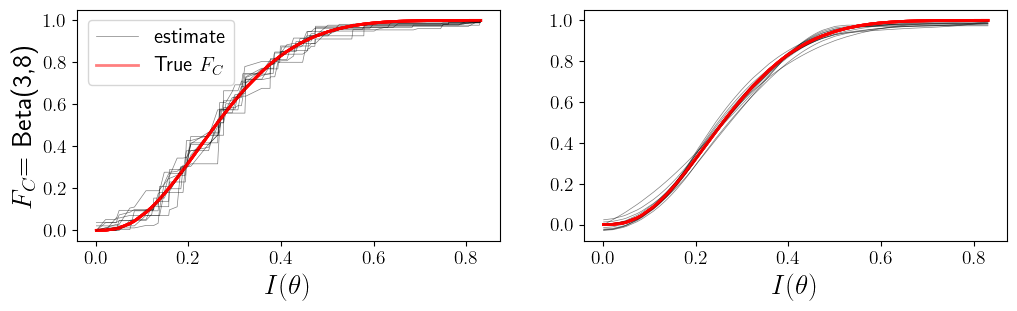

In [8]:
axis_font_size = 14
plt.figure(figsize=(12, 3))

iterable = range(evaluations)
for k in tqdm(iterable, desc="Processing items", unit="item", leave=False):
    pi = [F_C(x) for x in ordered_I_val] # Get the true pi
    pi_hat = get_pi_hat(theta,n,pi,plot_hist = False) # pi_hat = list of estimation of pi_t for each t

    # Subplot 1: Isotonic Regression
    plt.subplot(1, 2, 1)
        
    isotonic_regressor = IsotonicRegression()
    isotonic_fit = isotonic_regressor.fit_transform(ordered_I_val, pi_hat, sample_weight=n)
    plt.plot(ordered_I_val, isotonic_fit, label='estimate', color='black', linewidth=0.5, alpha=0.5)
    plt.plot(ordered_I_val, pi, label ="True $F_C$" ,color='red', linewidth=2, alpha=0.5)
    if k ==0:
        plt.xlabel(r'$I(\theta)$', fontsize=2 * plt.rcParams['font.size'])
        plt.ylabel('$F_C$= {}'.format(F_C_name), fontsize=2 * plt.rcParams['font.size'])
        plt.legend(fontsize=15, markerscale=2)
        plt.xticks(fontsize=axis_font_size) 
        plt.yticks(fontsize=axis_font_size)  
    
    plt.subplot(1, 2, 2)
    weights = n
    knots = 4
    plt.plot(ordered_I_val, mspl(ordered_I_val, pi_hat, weights , knots), label='estimate', color='black', linewidth=0.5, alpha=0.5)
    plt.plot(ordered_I_val, pi, label ="True $F_C$" ,color='red', linewidth=2, alpha=0.5)
    if k == 0:
        plt.xlabel('$I(\\theta)$', fontsize=2 * plt.rcParams['font.size'])
        plt.xticks(fontsize=axis_font_size)  
        plt.yticks(fontsize=axis_font_size)  

#plt.tight_layout()
# Save or show the plot
plt.savefig('plots/isotonic_vs_spline:{}.pdf'.format(F_C_name), bbox_inches='tight', dpi=300, transparent=False)
plt.show()